# Bayesian Risk Management

In [21]:
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
import pandas as pd
import pyfolio as pf
import numpy as np
import seaborn as sns
import pymc3 as pm
from pymc3.plots import forestplot, autocorrplot, compareplot, plot_posterior,traceplot
from scipy import stats
import empyrical as ep
import matplotlib.pyplot as plt
from matplotlib import gridspec

In [2]:
with pd.HDFStore('../data/assets.h5') as store:
    benchmark= store['sp500/prices'].close.to_frame('benchmark')
    returns = store['quandl/wiki/prices'].adj_close.unstack()['AMZN'].to_frame('stock')

In [3]:
data = returns.join(benchmark).pct_change().dropna().loc['2010':]
data.index = data.index.tz_localize('US/Eastern')

## Sharpe Ratio

### Define Probability Model

In [13]:
mean_prior = data.stock.mean()
std_prior = data.stock.std()
std_low = np.std(data.values) / 1000
std_high = np.std(data.values) * 1000

with pm.Model() as sharpe_model:
    mean = pm.Normal('mean',
                     mu=mean_prior,
                     tau=std_prior,
                     testval=data.stock.mean())

    std = pm.Uniform('std',
                     lower=std_low,
                     upper=std_high,
                     testval=data.stock.std())

    nu = pm.Exponential('nu_minus_two', 1 / 29, testval=4) + 2.
    returns = pm.StudentT('returns',
                          nu=nu,
                          mu=mean,
                          sd=std,
                          observed=data.stock)

    pm.Deterministic('sharpe',
                     returns.distribution.mean / returns.distribution.variance ** .5 * np.sqrt(252))
    trace = pm.sample(tune=2000,
                      draws=100000,
                      progressbar=True,
                      cores=8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [nu_minus_two, std, mean]
Sampling 8 chains: 100%|██████████| 816000/816000 [03:33<00:00, 3828.18draws/s]


### Visualize Model

In [7]:
sharpe_model.named_vars

{'mean': mean,
 'std_interval__': std_interval__,
 'std': std,
 'nu_minus_two_log__': nu_minus_two_log__,
 'nu_minus_two': nu_minus_two,
 'returns': returns,
 'sharpe': sharpe}

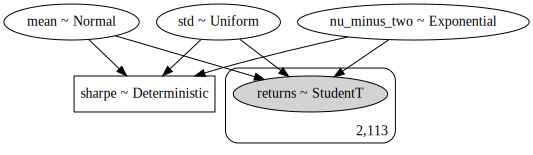

In [14]:
pm.model_to_graphviz(model=sharpe_model)

In [15]:
sharpe_model.model

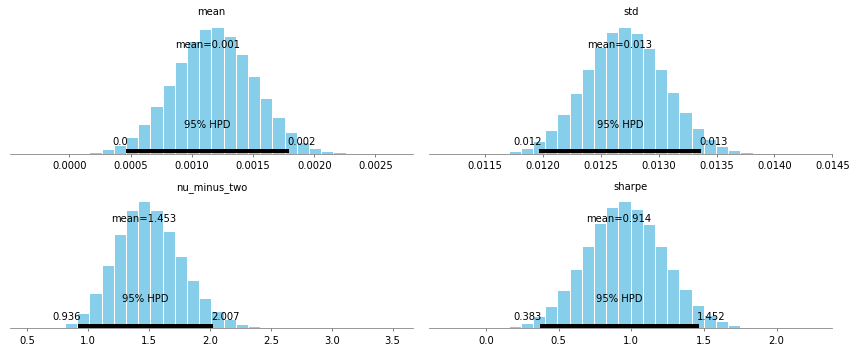

In [16]:
plot_posterior(trace=trace);

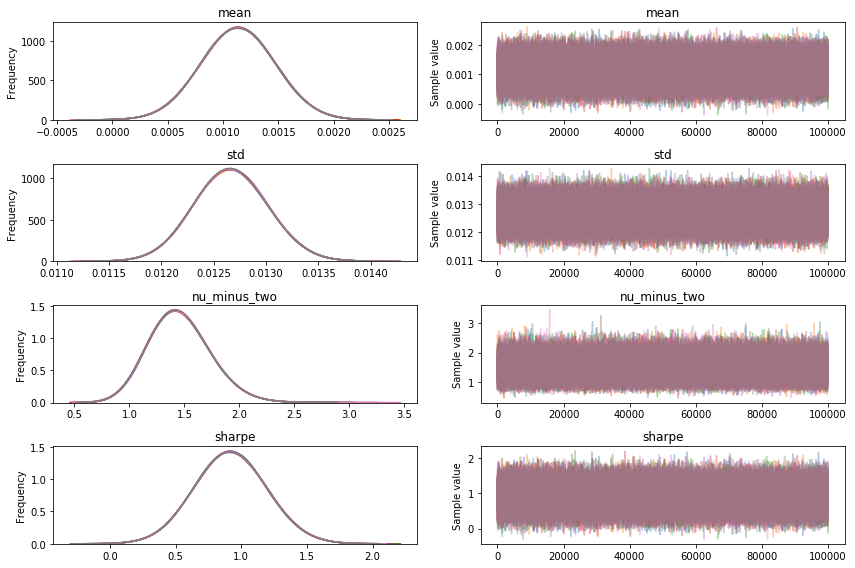

In [17]:
traceplot(trace=trace);

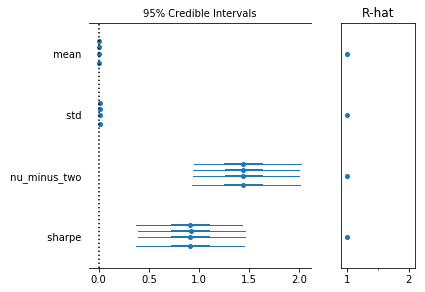

In [12]:
forestplot(trace=trace);

## Bayesian Estimation Supersedes the T-Test

This model runs a Bayesian hypothesis comparing if y1 and y2 come
from the same distribution. Returns are assumed to be T-distributed.

In addition, computes annual volatility and Sharpe of in and
out-of-sample periods.

This model replicates the example used in:
Kruschke, John. (2012) Bayesian estimation supersedes the t
test. Journal of Experimental Psychology: General.

In [18]:
mu_m = data.stock.mean()
mu_p = 0.000001 / data.var()

std_low = np.std(data.values) / 1000
std_high = np.std(data.values) * 1000
with pm.Model() as model:
    
    pf_mean = pm.Normal('pf_mean', mu=mu_m, tau=mu_p, testval=data.stock.mean())
    benchmark_mean = pm.Normal('benchmark_mean', mu=mu_m, tau=mu_p, testval=data.benchmark.mean())

    pf_std = pm.Uniform('pf_std', lower=std_low,upper=std_high, testval=data.stock.std())
    benchmark_std = pm.Uniform('benchmark_std', lower=std_low, upper=std_high, testval=data.benchmark.std())

    nu = pm.Exponential('nu_minus_two', 1 / 29., testval=4.) + 2.

    returns_pf = pm.StudentT('pf',
                             nu=nu,
                             mu=pf_mean,
                             lam=pf_std ** -2,
                             observed=data.stock)
    returns_benchmark = pm.StudentT('benchmark',
                                    nu=nu,
                                    mu=benchmark_mean,
                                    lam=benchmark_std ** -2,
                                    observed=data.benchmark)

    diff_of_means = pm.Deterministic('difference of means', pf_std - pf_mean)
    pm.Deterministic('difference of stds', benchmark_std - pf_std)
    pm.Deterministic('effect size', diff_of_means /
                     pm.math.sqrt((pf_std ** 2 + benchmark_std ** 2) / 2))

    pm.Deterministic(
        'pf_vol', returns_pf.distribution.variance ** .5 * np.sqrt(252))
    pm.Deterministic(
        'benchmark_vol', returns_benchmark.distribution.variance ** .5 * np.sqrt(252))

    pm.Deterministic('pf_sharpe', returns_pf.distribution.mean / returns_pf.distribution.variance ** .5 *
                     np.sqrt(252))
    pm.Deterministic('benchmark_sharpe', returns_benchmark.distribution.mean / returns_benchmark.distribution.variance ** .5 *
                     np.sqrt(252))

    trace = pm.sample(draws=50000, tune=2500, progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_minus_two, benchmark_std, pf_std, benchmark_mean, pf_mean]
Sampling 4 chains: 100%|██████████| 210000/210000 [02:19<00:00, 1508.88draws/s]


In [24]:
pm.trace_to_dataframe(trace).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196000 entries, 0 to 195999
Data columns (total 12 columns):
pf_mean                196000 non-null float64
benchmark_mean         196000 non-null float64
pf_std                 196000 non-null float64
benchmark_std          196000 non-null float64
nu_minus_two           196000 non-null float64
difference of means    196000 non-null float64
difference of stds     196000 non-null float64
effect size            196000 non-null float64
pf_vol                 196000 non-null float64
benchmark_vol          196000 non-null float64
pf_sharpe              196000 non-null float64
benchmark_sharpe       196000 non-null float64
dtypes: float64(12)
memory usage: 17.9 MB


No handles with labels found to put in legend.


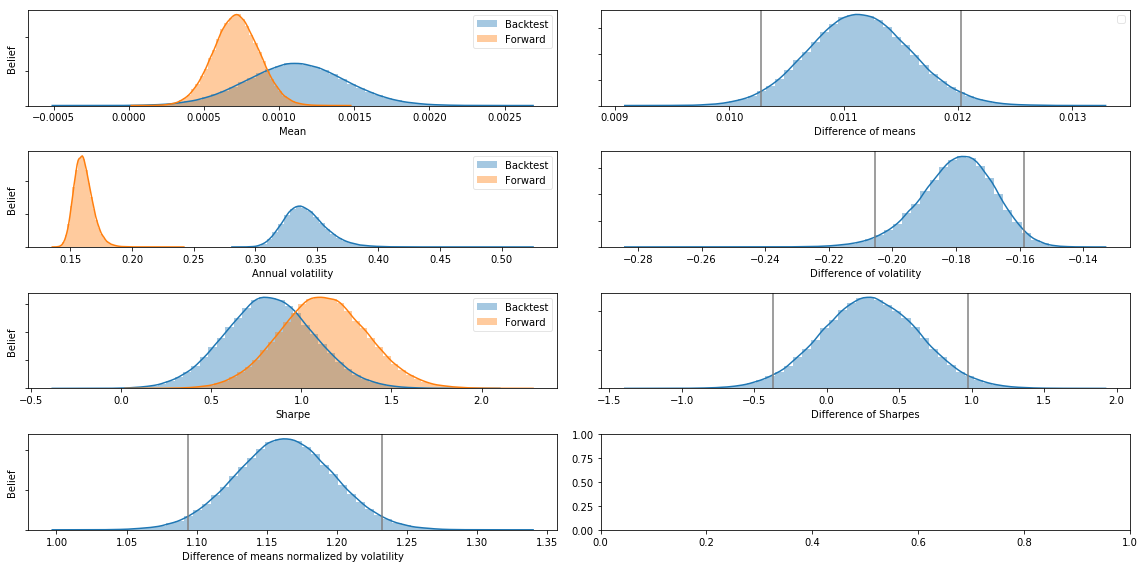

In [26]:
burn = 500
trace = trace[burn:]

fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(16, 8))
gs = gridspec.GridSpec(9, 2, wspace=0.3, hspace=0.3)
axs = axs.flatten()

def distplot_w_perc(trace, ax):
    sns.distplot(trace, ax=ax)
    ax.axvline(stats.scoreatpercentile(trace, 2.5), color='0.5', label='2.5 and 97.5 percentiles')
    ax.axvline(stats.scoreatpercentile(trace, 97.5), color='0.5')

sns.distplot(trace['pf_mean'], ax=axs[0], label='Backtest')
sns.distplot(trace['benchmark_mean'], ax=axs[0], label='Forward')
axs[0].legend(loc=0, frameon=True, framealpha=0.5)
axs[1].legend(loc=0, frameon=True, framealpha=0.5)

distplot_w_perc(trace['difference of means'], axs[1])

axs[0].set(xlabel='Mean', ylabel='Belief', yticklabels=[])
axs[1].set(xlabel='Difference of means', yticklabels=[])

sns.distplot(trace['pf_vol'], ax=axs[2], label='Backtest')
sns.distplot(trace['benchmark_vol'], ax=axs[2], label='Forward')
axs[2].set(xlabel='Annual volatility', ylabel='Belief', yticklabels=[])
axs[2].legend(loc=0, frameon=True, framealpha=0.5)

distplot_w_perc(trace['benchmark_vol'] - trace['pf_vol'], axs[3])
axs[3].set(xlabel='Difference of volatility', yticklabels=[])

sns.distplot(trace['pf_sharpe'], ax=axs[4], label='Backtest')
sns.distplot(trace['benchmark_sharpe'], ax=axs[4], label='Forward')
axs[4].set(xlabel='Sharpe', ylabel='Belief', yticklabels=[])
axs[4].legend(loc=0, frameon=True, framealpha=0.5)

distplot_w_perc(trace['benchmark_sharpe'] - trace['pf_sharpe'], axs[5])    
axs[5].set(xlabel='Difference of Sharpes', yticklabels=[])

sns.distplot(trace['effect size'], ax=axs[6])
axs[6].axvline(
        stats.scoreatpercentile(trace['effect size'], 2.5),
        color='0.5')
axs[6].axvline(
        stats.scoreatpercentile(trace['effect size'], 97.5),
        color='0.5')
axs[6].set(xlabel='Difference of means normalized by volatility',
           ylabel='Belief', yticklabels=[])
fig.tight_layout();

In [27]:
def plot_traces(traces, burnin=2000):
    ''' 
    Plot traces with overlaid means and values
    '''
    summary = pm.summary(traces[burnin:])
    lines = {k: v['mean']
             for k, v in summary.iterrows()}
    ax = pm.traceplot(traces[burnin:],
                      figsize=(15, len(traces.varnames)*1.5),
                      lines=lines)

    for i, mn in enumerate(summary['mean']):
        ax[i, 0].annotate(f'{mn:.2f}', 
                          xy=(mn, 0), 
                          xycoords='data', 
                          xytext=(5, 10), 
                          textcoords='offset points', 
                          rotation=90, 
                          va='bottom', 
                          fontsize='large', 
                          color='#AA0022')

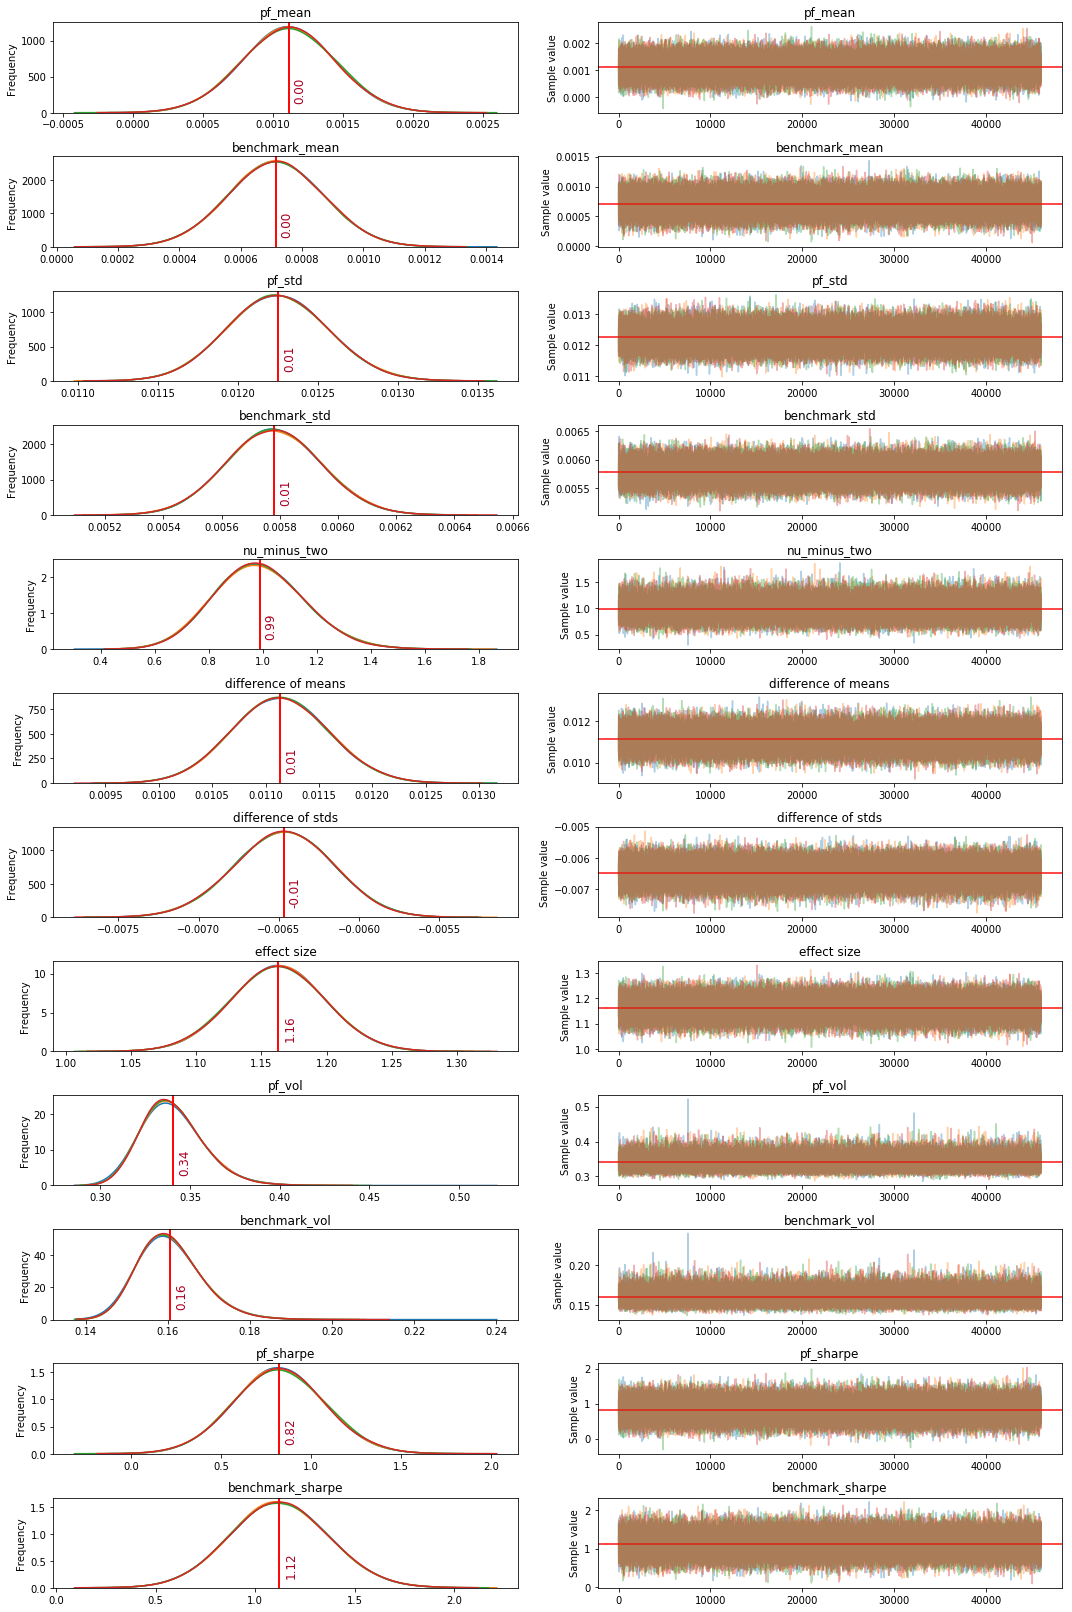

In [28]:
plot_traces(trace)